In [ ]:
!pip install scirpy

In [46]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.1 MB/s eta 0:00:00


In [47]:
pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 44.0 MB/s eta 0:00:00


In [94]:
import pandas as pd
import numpy as np
import scirpy as ir

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import roc_auc_score, accuracy_score

# ------------------------------------------------------------
# 1) Load VDJdb
# ------------------------------------------------------------
adata = ir.datasets.vdjdb()
df = adata.obs.copy()

cdr3b = ir.get.airr(adata, "junction_aa", chain="VDJ_1")
locus = ir.get.airr(adata, "locus", chain="VDJ_1")

df = df.join(cdr3b.rename("cdr3b")).join(locus.rename("locus"))
df = df.dropna(subset=["cdr3b", "locus"])
df = df[df["locus"].str.upper() == "TRB"]

# ------------------------------------------------------------
# 2) Detect epitope + MHC columns
# ------------------------------------------------------------
def find_col(columns, tokens):
    for c in columns:
        low = c.lower()
        if all(t in low for t in tokens):
            return c
    return None

epitope_col = find_col(df.columns, ["epitope"])
mhc_col = find_col(df.columns, ["mhc"]) or find_col(df.columns, ["hla"])

if epitope_col is None or mhc_col is None:
    raise ValueError("Could not detect epitope or MHC column")

# ------------------------------------------------------------
# 3) Restrict to one MHC allele (important!)
# ------------------------------------------------------------
df = df[df[mhc_col].astype(str).str.contains("HLA-A\\*02:01", na=False)]
df = df.dropna(subset=[epitope_col])

# Deduplicate TCR–epitope pairs
df = df.drop_duplicates(["cdr3b", epitope_col])

# ------------------------------------------------------------
# 4) Define feature encoders
# ------------------------------------------------------------
plus  = set("KRH")
minus = set("DE")
hydro = set("AVILMFWY")
polar = set("STNQGPC")

def aa2grp(a):
    if a in plus:  return "+"
    if a in minus: return "-"
    if a in hydro: return "H"
    return "P"

def center5(seq):
    if len(seq) < 5:
        return None
    mid = len(seq) // 2
    return seq[mid-2:mid+3]

def featurize_window(w, prefix):
    feats = {}
    for i, a in enumerate(w):
        g = aa2grp(a)
        for cat in ["H", "P", "+", "-"]:
            feats[f"{prefix}_pos{i}_{cat}"] = int(g == cat)
    return feats

# ------------------------------------------------------------
# 5) Build positive and mismatch-negative pairs
# ------------------------------------------------------------
rows = []

epitopes = df[epitope_col].unique()

for _, r in df.iterrows():
    w5 = center5(r["cdr3b"])
    if w5 is None:
        continue

    # positive
    rows.append({
        "cdr3b": r["cdr3b"],
        "epitope": r[epitope_col],
        "label": 1,
        "tcr_feats": featurize_window(w5, "tcr"),
        "pep_feats": featurize_window(r[epitope_col], "pep")
    })

    # negatives: mismatched epitopes
    neg_eps = np.random.choice(
        epitopes[epitopes != r[epitope_col]],
        size=min(3, len(epitopes)-1),
        replace=False
    )

    for e in neg_eps:
        rows.append({
            "cdr3b": r["cdr3b"],
            "epitope": e,
            "label": 0,
            "tcr_feats": featurize_window(w5, "tcr"),
            "pep_feats": featurize_window(e, "pep")
        })

# ------------------------------------------------------------
# 6) Build feature matrix
# ------------------------------------------------------------
X = []
y = []
epitope_ids = []

for r in rows:
    feats = {}
    feats.update(r["tcr_feats"])
    feats.update(r["pep_feats"])
    X.append(feats)
    y.append(r["label"])
    epitope_ids.append(r["epitope"])

X = pd.DataFrame(X).fillna(0).astype(int)
y = np.array(y)
epitope_ids = np.array(epitope_ids)

# ------------------------------------------------------------
# 7) Epitope-held-out split (CRITICAL)
# ------------------------------------------------------------
unique_eps = np.unique(epitope_ids)

train_eps, test_eps = train_test_split(
    unique_eps, test_size=0.2, random_state=0
)

train_mask = np.isin(epitope_ids, train_eps)
test_mask  = np.isin(epitope_ids, test_eps)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# ------------------------------------------------------------
# 8) Train interpretable model
# ------------------------------------------------------------
clf = DecisionTreeClassifier(
    max_depth=20,
    min_samples_leaf=2,
    random_state=0
)

clf.fit(X_train, y_train)

# ------------------------------------------------------------
# 9) Evaluate on unseen epitopes
# ------------------------------------------------------------
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

print("Unseen-epitope accuracy:", accuracy_score(y_test, y_pred))
print("Unseen-epitope AUC:     ", roc_auc_score(y_test, y_prob))

print("\nLearned rules:\n")
print(export_text(clf, feature_names=list(X.columns)))


Unseen-epitope accuracy: 0.8535862477771191
Unseen-epitope AUC:      0.6606160763870229

Learned rules:

|--- pep_pos3_P <= 0.50
|   |--- pep_pos3_+ <= 0.50
|   |   |--- pep_pos8_+ <= 0.50
|   |   |   |--- pep_pos6_P <= 0.50
|   |   |   |   |--- tcr_pos1_H <= 0.50
|   |   |   |   |   |--- tcr_pos3_+ <= 0.50
|   |   |   |   |   |   |--- pep_pos2_H <= 0.50
|   |   |   |   |   |   |   |--- tcr_pos0_- <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- tcr_pos0_- >  0.50
|   |   |   |   |   |   |   |   |--- pep_pos7_P <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- pep_pos7_P >  0.50
|   |   |   |   |   |   |   |   |   |--- tcr_pos2_H <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- tcr_pos2_H >  0.50
|   |   |   |   |   |   |   |   |   |   |--- tcr_pos1_P <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |  

In [95]:
sum(y_train)/len(y_train)

np.float64(0.2912428387700222)

In [96]:
sum(y_test)/len(y_test)

np.float64(0.04090100770598696)

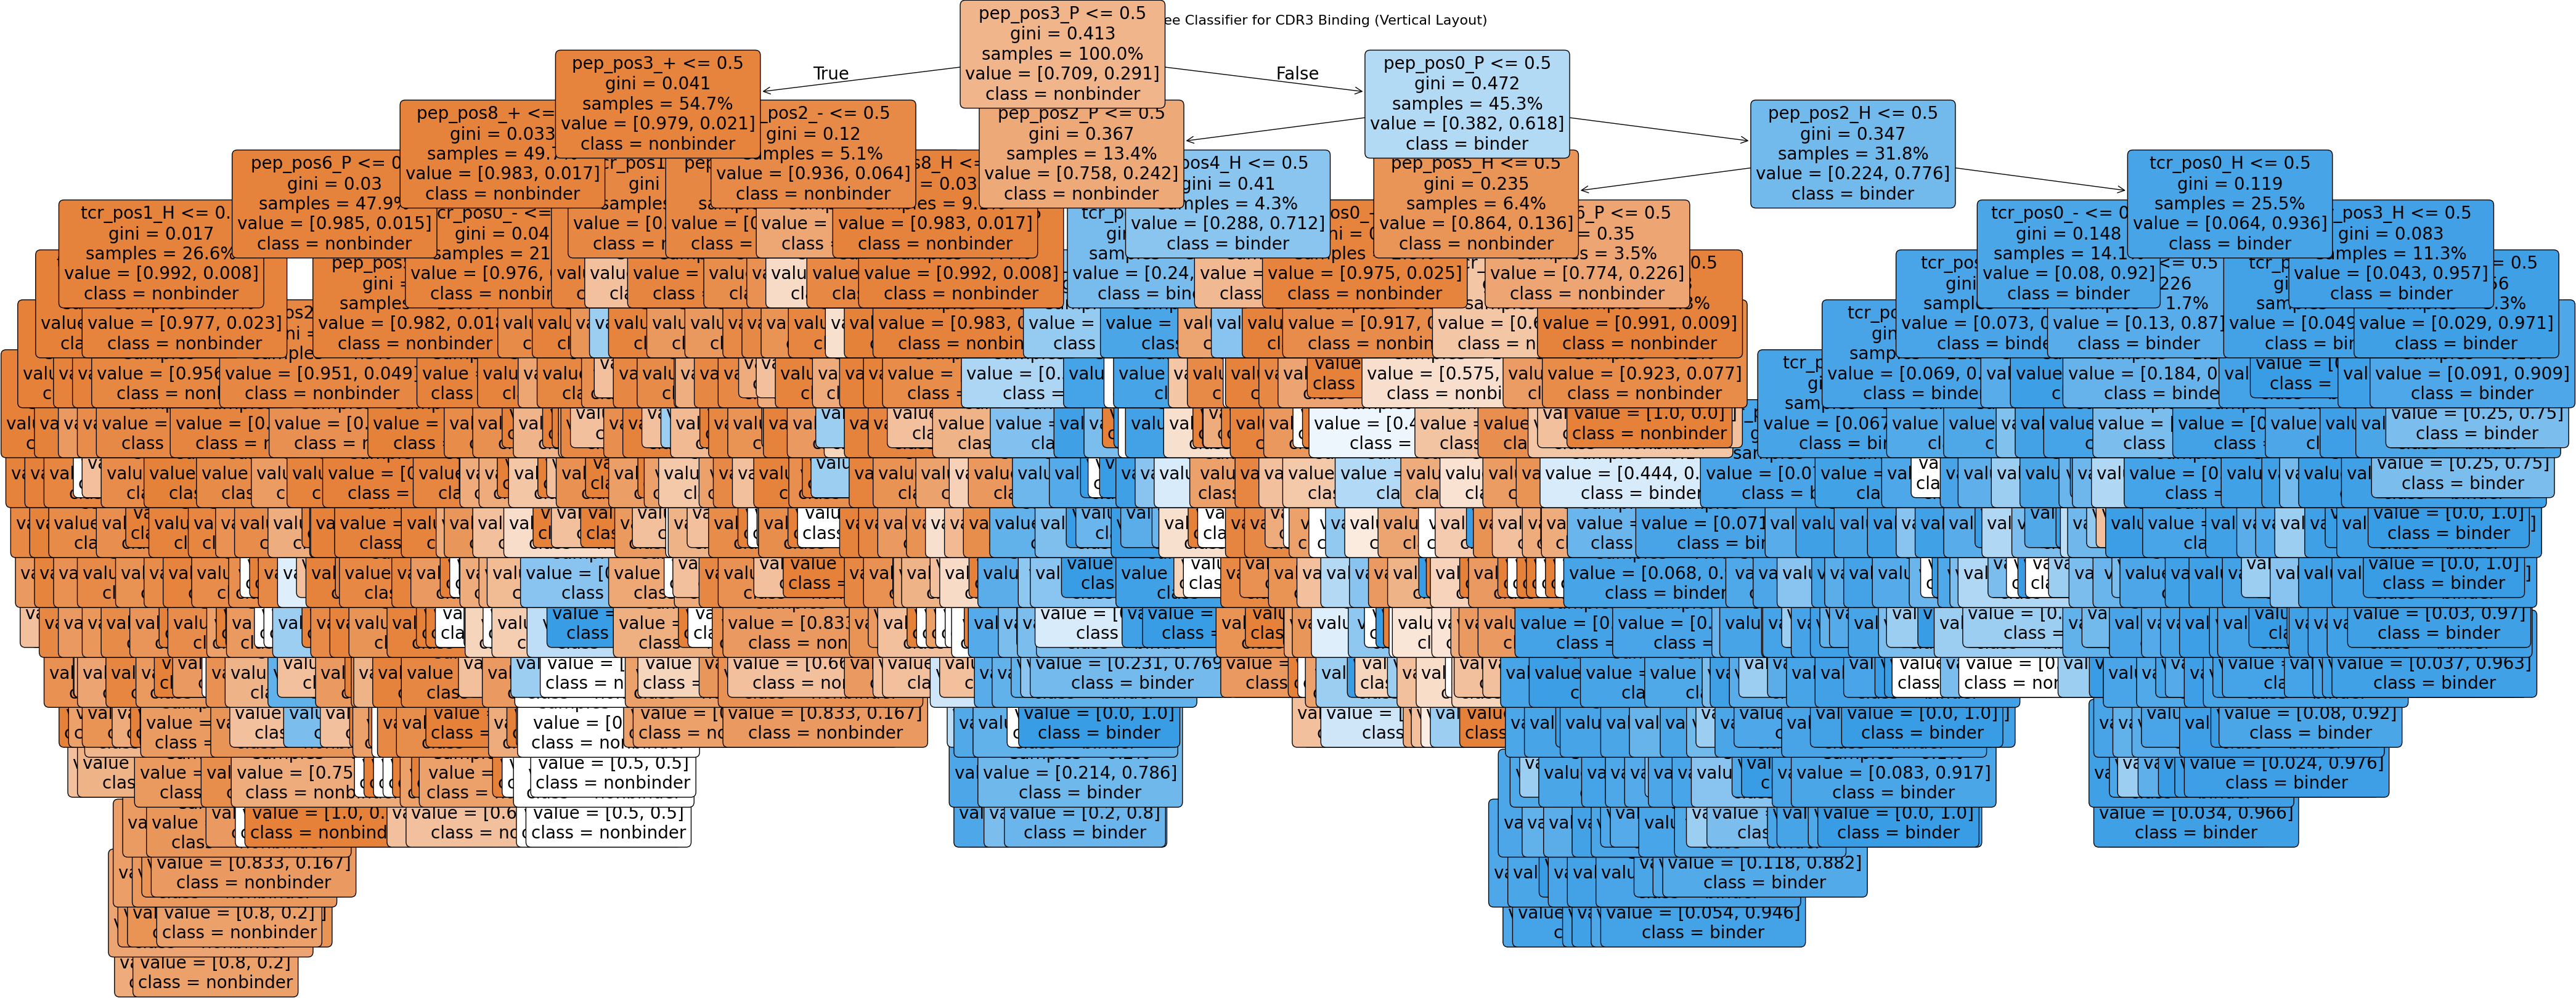

In [97]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(50, 20)) # Aumenta l'altezza rispetto alla larghezza per una visualizzazione più verticale
plot_tree(clf,
          feature_names=X.columns,
          class_names=['nonbinder', 'binder'],
          filled=True,
          rounded=True,
          proportion=True,
          fontsize=20)
plt.title("Decision Tree Classifier for CDR3 Binding (Vertical Layout)", fontsize=16)
plt.show()

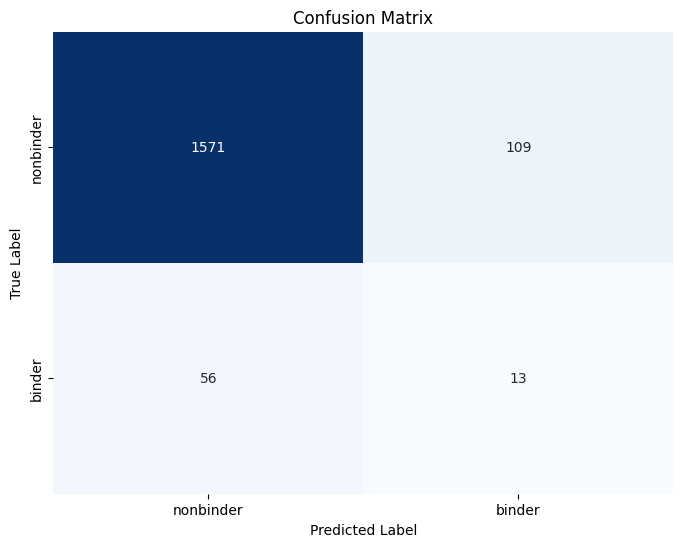

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Effettua le predizioni sul set di test
y_pred = clf.predict(X_test)

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Visualizza la matrice di confusione
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['nonbinder', 'binder'], yticklabels=['nonbinder', 'binder'], ax=ax)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calcola le metriche
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Accuracy:  0.9057
Precision: 0.1066
Recall:    0.1884
F1-Score:  0.1361


In [98]:
import re

def cond_to_readable(feature, op, threshold):
    # expects feature like "tcr_pos3_H" or "pep_pos1_+"
    m = re.match(r"(tcr|pep)_pos(\d+)_(H|P|\+|-)$", feature)
    if m and abs(threshold - 0.5) < 1e-6:
        prefix = m.group(1)
        pos = int(m.group(2))
        grp = m.group(3)
        if op == ">":
            return f"({prefix}_pos{pos} == '{grp}')"
        else:  # "<="
            return f"({prefix}_pos{pos} != '{grp}')"
    # fallback
    return f"({feature} {op} {threshold:g})"

def rules_to_dnf(rules):
    clauses = []
    for r in rules:
        clause = " and ".join(cond_to_readable(f,op,t) for f,op,t in r["conditions"])
        clauses.append(f"({clause})")
    return " or ".join(clauses) if clauses else "False"

In [99]:
import numpy as np

def extract_tree_rules(clf, feature_names, class_names=None, target_class=1):
    """
    Extract root->leaf rules from a fitted sklearn DecisionTreeClassifier.

    Returns a list of dicts:
      {
        "class": predicted_class,
        "class_name": ...,
        "conditions": [(feature, op, threshold), ...],
        "n_samples": int,
        "value": class_counts (array),
        "proba": class_probabilities (array)
      }
    """
    tree = clf.tree_
    feat = tree.feature
    thr = tree.threshold
    children_left = tree.children_left
    children_right = tree.children_right
    value = tree.value  # shape: (n_nodes, 1, n_classes)
    n_node_samples = tree.n_node_samples

    rules = []

    def recurse(node, path):
        is_leaf = (children_left[node] == children_right[node])
        if is_leaf:
            counts = value[node][0]
            pred_class = int(np.argmax(counts))
            if pred_class == target_class:
                probs = counts / counts.sum() if counts.sum() > 0 else counts
                rules.append({
                    "class": pred_class,
                    "class_name": class_names[pred_class] if class_names else str(pred_class),
                    "conditions": path.copy(),
                    "n_samples": int(n_node_samples[node]),
                    "value": counts.copy(),
                    "proba": probs.copy(),
                })
            return

        f_idx = feat[node]
        f_name = feature_names[f_idx]
        t = thr[node]

        # left: feature <= threshold
        recurse(children_left[node], path + [(f_name, "<=", float(t))])

        # right: feature > threshold
        recurse(children_right[node], path + [(f_name, ">", float(t))])

    recurse(0, [])
    return rules


In [100]:
feature_names = list(X.columns)
rules = extract_tree_rules(clf, feature_names, class_names=["nonbinder","binder"], target_class=1)

for i, r in enumerate(rules, 1):
    print(f"\nRule {i} (n={r["n_samples"]}, proba={r["proba"]}):")
    for f, op, t in r["conditions"]:
        print("  ", cond_to_readable(f, op, t))

print("\nDNF:")
print(rules_to_dnf(rules))


Rule 1 (n=2, proba=[0. 1.]):
   (pep_pos3 != 'P')
   (pep_pos3 != '+')
   (pep_pos8 != '+')
   (pep_pos6 == 'P')
   (tcr_pos0 != '-')
   (pep_pos5 != 'P')
   (tcr_pos2 == 'H')
   (tcr_pos0 != 'H')
   (tcr_pos3 == 'P')
   (pep_pos2 == '-')
   (tcr_pos4 != 'H')
   (tcr_pos1 != 'H')
   (tcr_pos1 != 'P')

Rule 2 (n=4, proba=[0.25 0.75]):
   (pep_pos3 != 'P')
   (pep_pos3 != '+')
   (pep_pos8 != '+')
   (pep_pos6 == 'P')
   (tcr_pos0 != '-')
   (pep_pos5 != 'P')
   (tcr_pos2 == 'H')
   (tcr_pos0 != 'H')
   (tcr_pos3 == 'P')
   (pep_pos2 == '-')
   (tcr_pos4 != 'H')
   (tcr_pos1 != 'H')
   (tcr_pos1 == 'P')

Rule 3 (n=2, proba=[0. 1.]):
   (pep_pos3 != 'P')
   (pep_pos3 != '+')
   (pep_pos8 != '+')
   (pep_pos6 == 'P')
   (tcr_pos0 != '-')
   (pep_pos5 == 'P')
   (tcr_pos3 == '+')
   (pep_pos2 == '+')
   (tcr_pos2 == '-')

Rule 4 (n=3, proba=[0.33333333 0.66666667]):
   (pep_pos3 != 'P')
   (pep_pos3 != '+')
   (pep_pos8 != '+')
   (pep_pos6 == 'P')
   (tcr_pos0 == '-')
   (tcr_pos2 == 'H')

In [101]:
def peptide_fixed_assignment(peptide, all_feature_names, plus, minus, hydro, polar):
    def aa2grp(a):
        if a in plus:  return "+"
        if a in minus: return "-"
        if a in hydro: return "H"
        return "P"

    # Start with all pep_* features set to 0
    fixed = {fn: 0 for fn in all_feature_names if fn.startswith("pep_")}

    # Set the 1s for positions that exist in this peptide
    for i, a in enumerate(peptide):
        g = aa2grp(a)
        for cat in ["H", "P", "+", "-"]:
            name = f"pep_pos{i}_{cat}"
            if name in fixed:
                fixed[name] = int(g == cat)

    return fixed


In [102]:
import numpy as np

def conditioned_tree_to_dnf_over_tcr(clf, feature_names, fixed_pep, positive_class=1):
    """
    Returns DNF clauses over NON-fixed features (i.e. tcr_*),
    by following peptide splits deterministically.
    Each clause: dict {feature_name: 0/1}
    Whole formula: OR over clauses.
    """
    tree = clf.tree_
    feat = tree.feature
    thr = tree.threshold
    left = tree.children_left
    right = tree.children_right
    value = tree.value

    clauses = []

    def is_leaf(n):
        return left[n] == right[n] == -1

    def leaf_class(n):
        return int(np.argmax(value[n][0]))

    def go(n, constraints):
        if is_leaf(n):
            if leaf_class(n) == positive_class:
                clause = {}
                ok = True
                for name, val in constraints:
                    if name in clause and clause[name] != val:
                        ok = False
                        break
                    clause[name] = val
                if ok:
                    clauses.append(clause)
            return

        fidx = feat[n]
        name = feature_names[fidx]
        t = thr[n]

        # (Your features are 0/1, so thresholds are basically 0.5)
        if name in fixed_pep:
            v = fixed_pep[name]
            # left: x <= t  (v==0 for t=0.5), right: x > t (v==1)
            if v <= t:
                go(left[n], constraints)
            else:
                go(right[n], constraints)
        else:
            # keep this split as a boolean literal in the clause
            go(left[n],  constraints + [(name, 0)])
            go(right[n], constraints + [(name, 1)])

    go(0, [])
    # Optionally: filter to only tcr_ literals (should already be, if fixed_pep covers all pep_)
    clauses = [{k:v for k,v in c.items() if k.startswith("tcr_")} for c in clauses]
    return clauses

def dnf_to_string(clauses, op_and=" & ", op_or=" | ", neg="~"):
    if not clauses:
        return "FALSE"
    parts = []
    for clause in clauses:
        lits = [(k if v == 1 else f"{neg}{k}") for k, v in sorted(clause.items())]
        parts.append("(" + op_and.join(lits) + ")")
    return op_or.join(parts)


In [103]:
# choose an unseen peptide (string) you want rules for
unseen_pep = "NLVPMVATV" #"CASSALASGGDTQYF" # example; use your peptide of interest

fixed_pep = peptide_fixed_assignment(
    unseen_pep,
    all_feature_names=list(X.columns),
    plus=plus, minus=minus, hydro=hydro, polar=polar
)

clauses_tcr = conditioned_tree_to_dnf_over_tcr(clf, list(X.columns), fixed_pep, positive_class=1)
formula_tcr_only = dnf_to_string(clauses_tcr)

print("Number of positive clauses (for this peptide):", len(clauses_tcr))
print(formula_tcr_only)


Number of positive clauses (for this peptide): 143
(~tcr_pos0_- & ~tcr_pos0_H & ~tcr_pos1_- & ~tcr_pos2_- & ~tcr_pos2_P & ~tcr_pos3_+ & ~tcr_pos3_- & ~tcr_pos3_H & ~tcr_pos4_- & ~tcr_pos4_P) | (~tcr_pos0_- & ~tcr_pos0_H & ~tcr_pos0_P & ~tcr_pos1_- & ~tcr_pos2_- & tcr_pos2_P & ~tcr_pos3_+ & ~tcr_pos3_- & ~tcr_pos3_H & ~tcr_pos4_- & ~tcr_pos4_P) | (~tcr_pos0_- & ~tcr_pos0_H & tcr_pos0_P & ~tcr_pos1_- & ~tcr_pos1_H & ~tcr_pos1_P & ~tcr_pos2_- & tcr_pos2_P & ~tcr_pos3_+ & ~tcr_pos3_- & ~tcr_pos3_H & ~tcr_pos4_- & ~tcr_pos4_H & ~tcr_pos4_P) | (~tcr_pos0_- & ~tcr_pos0_H & tcr_pos0_P & ~tcr_pos1_- & ~tcr_pos1_H & tcr_pos1_P & ~tcr_pos2_- & tcr_pos2_P & ~tcr_pos3_+ & ~tcr_pos3_- & ~tcr_pos3_H & ~tcr_pos4_- & ~tcr_pos4_H & ~tcr_pos4_P) | (~tcr_pos0_- & ~tcr_pos0_H & tcr_pos0_P & ~tcr_pos1_+ & ~tcr_pos1_- & ~tcr_pos1_H & ~tcr_pos2_- & tcr_pos2_P & ~tcr_pos3_+ & ~tcr_pos3_- & ~tcr_pos3_H & ~tcr_pos4_- & tcr_pos4_H & ~tcr_pos4_P) | (~tcr_pos0_- & ~tcr_pos0_H & tcr_pos0_P & tcr_pos1_+ & ~tcr_pos1_-

In [72]:
translated_pep = "".join([aa2grp(aa) for aa in unseen_pep])
print(f"Original peptide: {unseen_pep}")
print(f"Translated peptide: {translated_pep}")

Original peptide: CASSALASGGDTQYF
Translated peptide: PHPPHHHPPP-PPHH


## PART 2

In [ ]:
import math
from typing import List, Tuple

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import MCXGate
from qiskit_aer import Aer

# -------------------------
# 2-bit class encoding per position
# -------------------------
# 00 -> H (hydrophobic)
# 01 -> P (polar)
# 10 -> + (positively charged)
# 11 -> - (negatively charged)
BITS_TO_CLASS = {"00": "H", "01": "P", "10": "+", "11": "-"}
CLASS_TO_BITS = {v: k for k, v in BITS_TO_CLASS.items()}

# Data qubits (10): 5 positions × 2 bits
# pos0: q0=a0, q1=b0
# pos1: q2=a1, q3=b1
# pos2: q4=a2, q5=b2
# pos3: q6=a3, q7=b3
# pos4: q8=a4, q9=b4
#
# Ancillas:
# q10 = check ancilla #1 (parity check)
# q11 = check ancilla #2 (parity check)
#
# NOTE: We no longer use a phase ancilla |->. The oracle is implemented as an MCZ
# on the data qubits (via H–MCX–H), freeing q11 for checking.

CH_POS = set("KR")
CH_NEG = set("DE")

In [ ]:
def peptide_core(peptide: str, k: int = 3) -> str:
    p = peptide.strip().upper()
    if len(p) <= k:
        return p
    start = (len(p) - k) // 2
    return p[start:start + k]

def peptide_charge_sign(core: str) -> str:
    pos = sum(aa in CH_POS for aa in core)
    neg = sum(aa in CH_NEG for aa in core)
    if neg > pos:
        return "neg"
    if pos > neg:
        return "pos"
    return "none"

def decode_10bit_to_classes(data10_q0_to_q9: str) -> List[str]:
    return [BITS_TO_CLASS[data10_q0_to_q9[i:i+2]] for i in range(0, 10, 2)]

# -------------------------
# Predicate (classical)
# -------------------------
def predicate_classical(data10: str, peptide: str) -> bool:
    """
    More biologically interpretable toy rules:

    R1: pos0 == H
    R2: pos4 == H
    R3: pos2 == P
    R4: peptide-conditioned electrostatic contact:
        - if peptide core net neg -> pos1 == +
        - if peptide core net pos -> pos1 == -
        - if neutral -> pos1 is charged (+ or -)
    R5: pos3 not charged (avoid overly charged core): a3 == 0
    """
    if len(data10) != 10 or any(ch not in "01" for ch in data10):
        return False

    # unpack bits
    a0, b0 = int(data10[0]), int(data10[1])
    a1, b1 = int(data10[2]), int(data10[3])
    a2, b2 = int(data10[4]), int(data10[5])
    a3, b3 = int(data10[6]), int(data10[7])
    a4, b4 = int(data10[8]), int(data10[9])

    # R1/R2: anchors
    pos0_is_H = (a0 == 0 and b0 == 0)
    pos4_is_H = (a4 == 0 and b4 == 0)

    # R3: center polar (01)
    pos2_is_P = (a2 == 0 and b2 == 1)

    # R5: pos3 not charged -> a3 == 0
    pos3_not_charged = (a3 == 0)

    # R4: peptide-conditioned pos1 charge/sign
    core = peptide_core(peptide, 3)
    sign = peptide_charge_sign(core)

    if sign == "neg":
        # pos1 == +  (10)
        pos1_ok = (a1 == 1 and b1 == 0)
    elif sign == "pos":
        # pos1 == -  (11)
        pos1_ok = (a1 == 1 and b1 == 1)
    else:
        # neutral -> pos1 charged (a1 == 1), b1 can be 0/1
        pos1_ok = (a1 == 1)

    return pos0_is_H and pos4_is_H and pos2_is_P and pos1_ok and pos3_not_charged


def brute_force_solutions(peptide: str, limit_print: int = 12) -> Tuple[int, List[str]]:
    sols = []
    for x in range(2**10):
        s = format(x, "010b")  # q0..q9 order
        if predicate_classical(s, peptide):
            sols.append(s)

    print(f"[bruteforce] Peptide={peptide} core={peptide_core(peptide,3)} sign={peptide_charge_sign(peptide_core(peptide,3))}")
    print(f"[bruteforce] M = {len(sols)} solutions out of N = 1024")
    for s in sols[:limit_print]:
        print(" ", s, "->", decode_10bit_to_classes(s))
    if len(sols) > limit_print:
        print(f"... (showing first {limit_print} of {len(sols)})")
    return len(sols), sols

# -------------------------
# Quantum phase oracle for the SAME predicate (NO phase ancilla)
# -------------------------
def phase_oracle_predicate(peptide: str) -> QuantumCircuit:
    """
    Implements a phase flip on the data register iff predicate holds,
    using an MCZ realized as H(target) - MCX(controls->target) - H(target).

    Uses ONLY data qubits; q10/q11 are left untouched for checks.
    """
    qc = QuantumCircuit(12, name="Oracle(bio,MCZ)")

    # Indices (data)
    a0, b0 = 0, 1
    a1, b1 = 2, 3
    a2, b2 = 4, 5
    a3, b3 = 6, 7
    a4, b4 = 8, 9

    # Determine which pos1 condition applies
    core = peptide_core(peptide, 3)
    sign = peptide_charge_sign(core)

    # Apply X for 0-controls (map desired 0-literals into 1-controls)
    qc.x(a0); qc.x(b0)  # pos0 == 00
    qc.x(a4); qc.x(b4)  # pos4 == 00
    qc.x(a2)            # pos2 == 01 => a2=0, b2=1
    qc.x(a3)            # pos3 not charged => a3=0

    # Base controls (must be |1> after mapping)
    controls = [a0, b0, a4, b4, a2, b2, a3]  # b2 is required 1, no X on b2

    # pos1 controls depending on peptide sign
    if sign == "neg":
        # pos1 == 10 => a1=1, b1=0
        qc.x(b1)         # map b1=0 to b1=1 control
        controls += [a1, b1]
    elif sign == "pos":
        # pos1 == 11 => a1=1, b1=1
        controls += [a1, b1]
    else:
        # neutral => a1=1 (charged)
        controls += [a1]

    # Multi-controlled Z on all controls:
    # pick a target qubit from the controls list; apply H-target, MCX, H-target.
    # This phase-flips exactly when ALL controls are 1.
    if len(controls) < 2:
        # (Shouldn't happen here, but keep it safe.)
        qc.z(controls[0])
    else:
        target = controls[-1]
        ctrl_rest = controls[:-1]
        qc.h(target)
        qc.append(MCXGate(len(ctrl_rest)), ctrl_rest + [target])
        qc.h(target)

    # Uncompute X-maps
    if sign == "neg":
        qc.x(b1)

    qc.x(a3)
    qc.x(a2)
    qc.x(b4); qc.x(a4)
    qc.x(b0); qc.x(a0)

    return qc

# -------------------------
# Grover diffuser on data register only (q0..q9)
# -------------------------
def diffuser_on_data_10() -> QuantumCircuit:
    qc = QuantumCircuit(12, name="Diffuser(data10)")
    data = list(range(10))

    qc.h(data)
    qc.x(data)

    target = data[-1]
    controls = data[:-1]
    qc.h(target)
    qc.append(MCXGate(len(controls)), controls + [target])
    qc.h(target)

    qc.x(data)
    qc.h(data)
    return qc

# -------------------------
# Add lightweight error-detection checks (2 parities) using q10,q11
# -------------------------
def add_anchor_parity_checks(qc: QuantumCircuit, check1: int = 10, check2: int = 11):
    """
    Compute two simple parity checks that SHOULD be 0 for valid states:
      check1 = a0 XOR a4  (q0 XOR q8)
      check2 = b0 XOR b4  (q1 XOR q9)

    Measure these ancillas and postselect on 00.
    """
    qc.reset(check1)
    qc.reset(check2)

    # check1 = a0 XOR a4
    qc.cx(0, check1)
    qc.cx(8, check1)

    # check2 = b0 XOR b4
    qc.cx(1, check2)
    qc.cx(9, check2)

# -------------------------
# Build Grover circuit
# -------------------------
def build_grover_circuit(peptide: str, iters: int) -> QuantumCircuit:
    oracle = phase_oracle_predicate(peptide)
    diff = diffuser_on_data_10()

    # Measure: 10 data bits + 2 check bits
    qc = QuantumCircuit(12, 12)
    data = list(range(10))
    check1, check2 = 10, 11

    # data superposition
    qc.h(data)

    for _ in range(iters):
        qc.append(oracle, range(12))
        qc.append(diff, range(12))

    # Compute check bits at the end (error detection via postselection)
    add_anchor_parity_checks(qc, check1=check1, check2=check2)

    # Measure q0..q9 -> c0..c9
    qc.measure(data, list(range(10)))
    # Measure checks -> c10,c11
    qc.measure(check1, 10)
    qc.measure(check2, 11)

    assert qc.num_qubits == 12
    return qc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -F '/content/drive'

MyDrive/  Othercomputers/


In [ ]:
import pandas as pd
plus  = set("KRH")
minus = set("DE")
hydro = set("AVILMFWY")
polar = set("STNQGPC")  # coarse grouping

def aa2grp(a):
    if a in plus:  return "+"
    if a in minus: return "-"
    if a in hydro: return "H"
    return "P"

aa_validation = pd.read_csv("/content/drive/MyDrive/RP0205_BEATIT/RP05_bioinfo_club/quantum/aa_table.csv", index_col=0)

In [ ]:
aa_validation.head()

,Cys,Met,Phe,Ile,Leu,Val,Trp,Tyr,Ala,Gly,Thr,Ser,Asn,Gln,Asp,Glu,His,Arg,Lys,Pro
Cys,-5.44,-4.99,-5.80,-5.50,-5.83,-4.96,-4.95,-4.16,-3.57,-3.16,-3.11,-2.86,-2.59,-2.85,-2.41,-2.27,-3.60,-2.57,-1.95,-3.07
Met,0.46,-5.46,-6.56,-6.02,-6.41,-5.32,-5.55,-4.91,-3.94,-3.39,-3.51,-3.03,-2.95,-3.30,-2.57,-2.89,-3.98,-3.12,-2.48,-3.45
Phe,0.54,-0.20,-7.26,-6.84,-7.28,-6.29,-6.16,-5.66,-4.81,-4.13,-4.28,-4.02,-3.75,-4.10,-3.48,-3.56,-4.77,-3.98,-3.36,-4.25
Ile,0.49,-0.01,0.06,-6.54,-7.04,-6.05,-5.78,-5.25,-4.58,-3.78,-4.03,-3.52,-3.24,-3.67,-3.17,-3.27,-4.14,-3.63,-3.01,-3.76
Leu,0.57,0.01,0.03,-0.08,-7.37,-6.48,-6.14,-5.67,-4.91,-4.16,-4.34,-3.92,-3.74,-4.04,-3.40,-3.59,-4.54,-4.03,-3.37,-4.20


In [ ]:
aa_map_short_to_1_letter = {
    'Cys': 'C', 'Met': 'M', 'Phe': 'F', 'Ile': 'I', 'Leu': 'L', 'Val': 'V',
    'Trp': 'W', 'Tyr': 'Y', 'Ala': 'A', 'Gly': 'G', 'Thr': 'T', 'Ser': 'S',
    'Asn': 'N', 'Gln': 'Q', 'Asp': 'D', 'Glu': 'E', 'His': 'H', 'Arg': 'R',
    'Lys': 'K', 'Pro': 'P'
}

aa_validation_1_letter = aa_validation.rename(index=aa_map_short_to_1_letter, columns=aa_map_short_to_1_letter)
aa_validation_1_letter.head()

,C,M,F,I,L,V,W,Y,A,G,T,S,N,Q,D,E,H,R,K,P
C,-5.44,-4.99,-5.80,-5.50,-5.83,-4.96,-4.95,-4.16,-3.57,-3.16,-3.11,-2.86,-2.59,-2.85,-2.41,-2.27,-3.60,-2.57,-1.95,-3.07
M,0.46,-5.46,-6.56,-6.02,-6.41,-5.32,-5.55,-4.91,-3.94,-3.39,-3.51,-3.03,-2.95,-3.30,-2.57,-2.89,-3.98,-3.12,-2.48,-3.45
F,0.54,-0.20,-7.26,-6.84,-7.28,-6.29,-6.16,-5.66,-4.81,-4.13,-4.28,-4.02,-3.75,-4.10,-3.48,-3.56,-4.77,-3.98,-3.36,-4.25
I,0.49,-0.01,0.06,-6.54,-7.04,-6.05,-5.78,-5.25,-4.58,-3.78,-4.03,-3.52,-3.24,-3.67,-3.17,-3.27,-4.14,-3.63,-3.01,-3.76
L,0.57,0.01,0.03,-0.08,-7.37,-6.48,-6.14,-5.67,-4.91,-4.16,-4.34,-3.92,-3.74,-4.04,-3.40,-3.59,-4.54,-4.03,-3.37,-4.20


In [ ]:
aa_categories = pd.DataFrame({
    'Amino Acid': aa_validation.index,
    'Category': [aa2grp(aa_map_short_to_1_letter[aa]) for aa in aa_validation.index]
})
aa_categories["Category"].value_counts()

,count
Category,
H,8
P,7
+,3
-,2


In [ ]:
import numpy as np

# Create a mapping from single-letter amino acid codes to their categories
single_letter_to_category_map = {
    aa_map_short_to_1_letter[aa_name]: category
    for aa_name, category in zip(aa_categories['Amino Acid'], aa_categories['Category'])
}

# Define the categories
categories = ['H', 'P', '+', '-']

# Initialize an empty DataFrame for the category-averaged matrix
category_avg_matrix = pd.DataFrame(index=categories, columns=categories, dtype=float)

# Populate the matrix by calculating averages for each category pair
for row_cat in categories:
    # Get all single-letter AAs belonging to the current row category
    row_aas = [aa_char for aa_char, cat in single_letter_to_category_map.items() if cat == row_cat]

    for col_cat in categories:
        # Get all single-letter AAs belonging to the current column category
        col_aas = [aa_char for aa_char, cat in single_letter_to_category_map.items() if cat == col_cat]

        # Ensure there are amino acids for both categories before attempting to slice
        if row_aas and col_aas:
            # Extract the sub-matrix of interaction energies
            sub_matrix = aa_validation_1_letter.loc[row_aas, col_aas]

            # Calculate the average and store it in the new matrix
            category_avg_matrix.loc[row_cat, col_cat] = sub_matrix.mean().mean()
        else:
            # If no amino acids exist for a category, set the value to NaN
            category_avg_matrix.loc[row_cat, col_cat] = float('nan')
category_avg_matrix_abs= np.abs(category_avg_matrix)
# Display the resulting category-averaged matrix
display(category_avg_matrix_abs)

,H,P,+,-
H,3.068437,2.773214,3.269167,2.854375
P,0.406429,1.126939,1.594762,1.428571
+,0.272917,0.106667,0.912222,0.765000
-,0.433125,0.125000,2.085000,0.772500


In [ ]:

# -------------------------
# Run (simulator) + compare to brute force
# -------------------------
if __name__ == "__main__":
    peptide = "GLCTLVAML"  # replace

    M, sols = brute_force_solutions(peptide, limit_print=8)
    N = 2**10

    # Good iteration heuristic
    iters = max(1, int(round((math.pi / 4) * math.sqrt(N / max(1, M)))))
    print(f"[grover] Using iters = {iters} (based on M={M})")

    qc = build_grover_circuit(peptide, iters=iters)
    print("[grover] Circuit qubits:", qc.num_qubits)

    backend = Aer.get_backend("aer_simulator")
    tqc = transpile(qc, backend=backend, optimization_level=1)
    res = backend.run(tqc, shots=2048).result()
    counts = res.get_counts()

    def key_to_c0_to_c11(key: str) -> str:
        # Qiskit returns c11..c0 as a string; reverse to get c0..c11
        return key[::-1]

    def split_data_and_checks(key: str) -> Tuple[str, str]:
        c = key_to_c0_to_c11(key)
        data10 = c[:10]       # c0..c9 corresponds to q0..q9 measurements
        checks = c[10:12]     # c10..c11 corresponds to q10,q11 checks
        return data10, checks

    top = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:15]
    print("\nTop measured results (showing check bits):")
    for key, ct in top:
        data10, checks = split_data_and_checks(key)
        ok = predicate_classical(data10, peptide)
        chk_ok = (checks == "00")
        tag = "VALID+CHK" if (ok and chk_ok) else ("VALID" if ok else ("CHK" if chk_ok else ""))
        print(f"{key}  {ct:4d}  q0..q9={data10}  checks(c10,c11)={checks}  {decode_10bit_to_classes(data10)}  {tag}")

    # Raw VALID rate (ignoring checks)
    valid_shots = 0
    for key, ct in counts.items():
        data10, _ = split_data_and_checks(key)
        if predicate_classical(data10, peptide):
            valid_shots += ct
    print(f"\nVALID shots (raw) = {valid_shots} / 2048  ({valid_shots/2048:.3f})")

    # Postselected VALID rate (keep only checks==00)
    kept_shots = 0
    valid_kept_shots = 0
    for key, ct in counts.items():
        data10, checks = split_data_and_checks(key)
        if checks == "00":
            kept_shots += ct
            if predicate_classical(data10, peptide):
                valid_kept_shots += ct

    if kept_shots > 0:
        print(f"Postselected on checks==00: kept = {kept_shots} / 2048  ({kept_shots/2048:.3f})")
        print(f"VALID among kept = {valid_kept_shots} / {kept_shots}  ({valid_kept_shots/kept_shots:.3f})")
    else:
        print("Postselected on checks==00: kept = 0 (no shots passed checks)")


[bruteforce] Peptide=GLCTLVAML core=TLV sign=none
[bruteforce] M = 4 solutions out of N = 1024
  0010010000 -> ['H', '+', 'P', 'H', 'H']
  0010010100 -> ['H', '+', 'P', 'P', 'H']
  0011010000 -> ['H', '-', 'P', 'H', 'H']
  0011010100 -> ['H', '-', 'P', 'P', 'H']
[grover] Using iters = 13 (based on M=4)
[grover] Circuit qubits: 12

Top measured results (showing check bits):
000010101100   522  q0..q9=0011010100  checks(c10,c11)=00  ['H', '-', 'P', 'P', 'H']  VALID+CHK
000000100100   514  q0..q9=0010010000  checks(c10,c11)=00  ['H', '+', 'P', 'H', 'H']  VALID+CHK
000000101100   512  q0..q9=0011010000  checks(c10,c11)=00  ['H', '-', 'P', 'H', 'H']  VALID+CHK
000010100100   476  q0..q9=0010010100  checks(c10,c11)=00  ['H', '+', 'P', 'P', 'H']  VALID+CHK
001111001011     1  q0..q9=1101001111  checks(c10,c11)=00  ['-', 'P', 'H', '-', '-']  CHK
100110111011     1  q0..q9=1101110110  checks(c10,c11)=01  ['-', 'P', '-', 'P', '+']  
000011110000     1  q0..q9=0000111100  checks(c10,c11)=00  ['H'

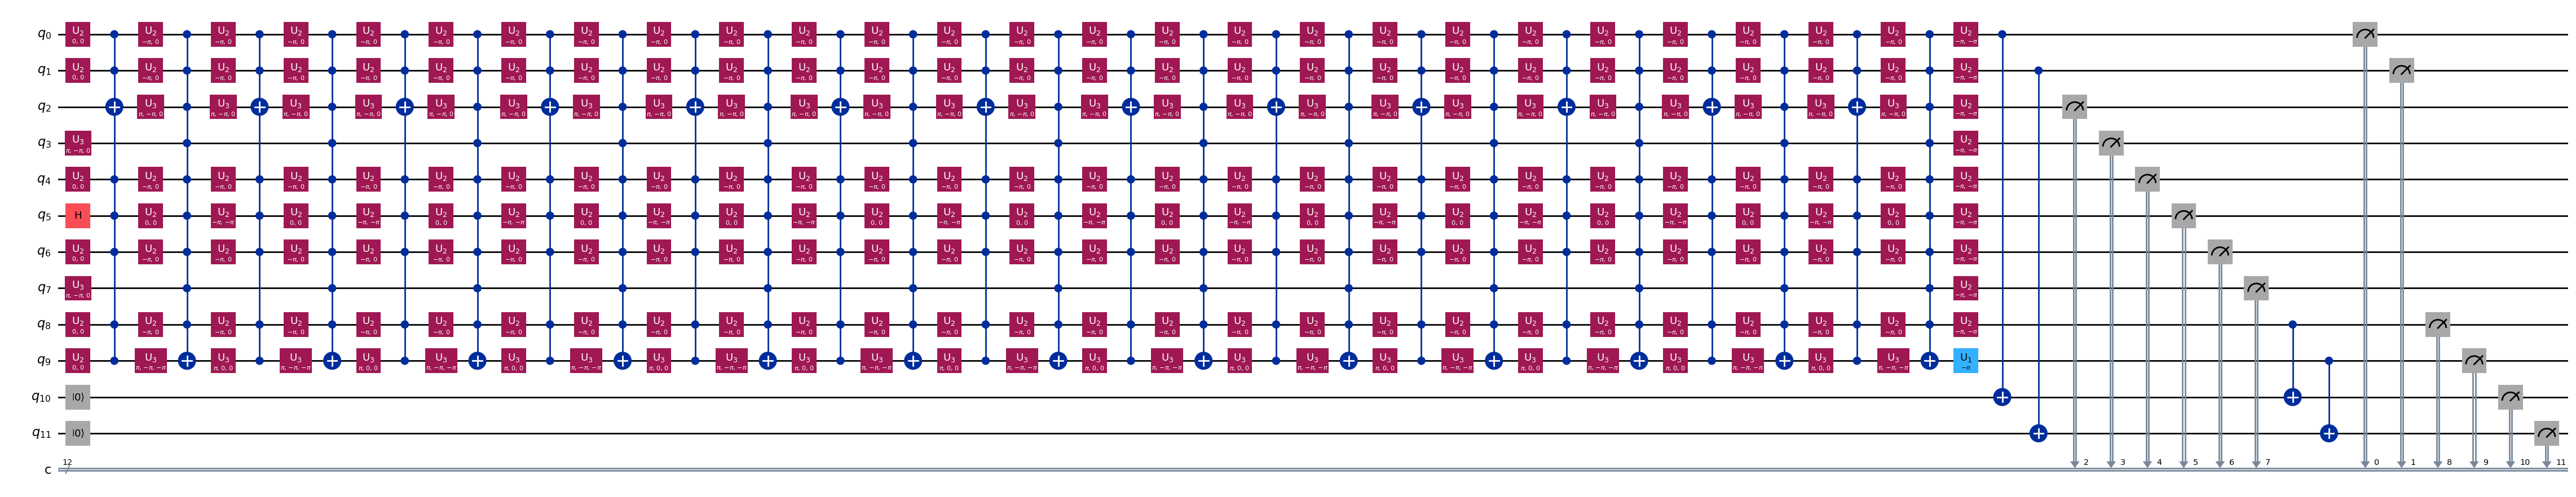

In [ ]:
from qiskit_aer import Aer
backend = Aer.get_backend("aer_simulator")

qc = build_grover_circuit(peptide, iters=iters)
tqc = transpile(qc, backend=backend, optimization_level=1)

import matplotlib.pyplot as plt
tqc.draw(output="mpl", fold=200)


# Task
Extract the central 5 amino acids from the `peptide` variable, convert them into their corresponding categories (H, P, +, -) using the `aa2grp` function and `aa_map_short_to_1_letter`. Then, define a Python function to score 10-bit solution strings by decoding them into 5 amino acid categories, and for each position, sum the interaction energies from `category_avg_matrix_abs` using the decoded solution category as the row and the peptide core category as the column. Apply this scoring function to the `sols` list, rank the solutions by score in descending order, and finally, print each ranked solution, its decoded categories, its score, and the label 'BIO'.

## Extract and Categorize Peptide Core

### Subtask:
Extract the central 5 amino acids from the `peptide` variable and convert them into their corresponding categories (H, P, +, -).


**Reasoning**:
The subtask requires extracting the central 5 amino acids from the 'peptide' variable and converting them to categories. I will write a Python code block to perform these steps, including determining the start and end indices, extracting the core, applying the `aa2grp` function to each amino acid, and storing the results in a list, then print the result.



In [ ]:
peptide = 'GLCTLVAML'

# 2. Determine the start and end indices to extract the central 5 amino acids
# For a 9-letter peptide, length = 9. (9 - 5) // 2 = 4 // 2 = 2. So start from index 2.
# End index will be start + 5 = 2 + 5 = 7.
start_index = (len(peptide) - 5) // 2
end_index = start_index + 5

# 3. Extract this 5-amino acid core
peptide_5_core = peptide[start_index:end_index]
print(f"Original peptide: {peptide}")
print(f"Extracted 5-amino acid core: {peptide_5_core}")

# 4. For each amino acid in the peptide_5_core, convert it into its category
# 5. Store these 5 categories in a list
peptide_5_core_categories = [aa2grp(aa) for aa in peptide_5_core]
print(f"Categories for the 5-amino acid core: {peptide_5_core_categories}")

Original peptide: GLCTLVAML
Extracted 5-amino acid core: CTLVA
Categories for the 5-amino acid core: ['P', 'P', 'H', 'H', 'H']


**Reasoning**:
I need to define a Python function to score the 10-bit solution strings. This function will decode each solution into 5 amino acid categories, then calculate a score based on the `category_avg_matrix_abs` and the `peptide_5_core_categories` for each position. The function will then be applied to the `sols` list to score each solution.



In [ ]:
def score_solution(solution_bits: str, peptide_core_categories: List[str]) -> float:
    decoded_categories = decode_10bit_to_classes(solution_bits)
    score = 0.0
    for i in range(5):
        sol_cat = decoded_categories[i]
        core_cat = peptide_core_categories[i]
        # Get interaction energy from the absolute value matrix
        interaction_energy = category_avg_matrix_abs.loc[sol_cat, core_cat]
        score += interaction_energy
    return score

# Apply the scoring function to the sols list
scored_solutions = []
for sol_str in sols:
    score = score_solution(sol_str, peptide_5_core_categories)
    scored_solutions.append((sol_str, score))

# Rank solutions by score in descending order
ranked_solutions = sorted(scored_solutions, key=lambda x: x[1], reverse=True)

# Print each ranked solution
print("\nRanked Solutions by BIO score (descending):")
for sol_str, score in ranked_solutions:
    decoded_cats = decode_10bit_to_classes(sol_str)
    print(f"Solution: {sol_str} -> Decoded: {decoded_cats} -> Score: {score:.3f} BIO")


Ranked Solutions by BIO score (descending):
Solution: 0011010000 -> Decoded: ['H', '-', 'P', 'H', 'H'] -> Score: 9.442 BIO
Solution: 0010010000 -> Decoded: ['H', '+', 'P', 'H', 'H'] -> Score: 9.423 BIO
Solution: 0011010100 -> Decoded: ['H', '-', 'P', 'P', 'H'] -> Score: 6.780 BIO
Solution: 0010010100 -> Decoded: ['H', '+', 'P', 'P', 'H'] -> Score: 6.761 BIO


## Final Task

### Subtask:
Summarize the process of scoring and ranking solutions based on the category interaction matrix.


## Summary:

### Data Analysis Key Findings
*   The central 5 amino acids of the peptide 'GLCTLVAML' were successfully extracted as 'CTLVA'.
*   These extracted core amino acids were categorized as `['P', 'P', 'H', 'H', 'H']` (P: Polar, H: Hydrophobic).
*   A `score_solution` function was implemented to evaluate 10-bit solution strings. This function decodes the 10-bit string into 5 amino acid categories and calculates a total score by summing interaction energies from `category_avg_matrix_abs` for each position, based on the decoded solution category and the peptide core category.
*   The solutions from the `sols` list were scored using this function and subsequently ranked in descending order based on their calculated scores. Each ranked solution was printed along with its original bit string, its decoded amino acid categories, and its corresponding numerical score, followed by the label 'BIO'.

### Insights or Next Steps
*   The established scoring and ranking methodology offers a robust framework for systematically evaluating and prioritizing potential solutions based on their predicted interaction energies with a target peptide core.
*   Further analysis of the top-ranked solutions could reveal optimal amino acid category sequences that exhibit strong interactions with the 'CTLVA' core, providing valuable insights for design or optimization.
